<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/nlp/karpathy/makemore_part2_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

paper : [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open('names.txt',"r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [ ]:
len(words)

32033

In [ ]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape,X.dtype,Y.shape,Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
C = torch.rand((27,2))

In [ ]:
C[5]

tensor([0.9435, 0.1561])

In [ ]:
# F.one_hot(torch.tensor(5),num_classes = 27).float() @ C


In [ ]:
C[torch.tensor([2,3,4])]

tensor([[0.4475, 0.3671],
        [0.6406, 0.5894],
        [0.8778, 0.5276]])

In [ ]:
C[X].shape

torch.Size([32, 3, 2])

In [ ]:
X[13,2]

tensor(1)

In [ ]:
C[X][13,2]

tensor([0.2649, 0.2045])

In [ ]:
emb = C[X]
emb.size()

torch.Size([32, 3, 2])

In [ ]:
W1 = torch.randn(6,100)
b1 = torch.randn(100)

In [ ]:
h = torch.tanh(emb.view(emb.size(0),-1) @ W1 + b1)

In [ ]:
# torch.cat((emb[:,0,:],emb[:,1,:],emb[:,2,:]),1).shape
# torch.cat(torch.unbind(emb,1),1).shape

In [ ]:
h.shape

torch.Size([32, 100])

In [ ]:
(emb.view(-1,6) @ W1).shape

torch.Size([32, 100])

In [ ]:
b1.shape

torch.Size([100])

In [ ]:
#32 100
#1  100

In [ ]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [ ]:
logits =  h @ W2 + b2

In [ ]:
logits.shape

torch.Size([32, 27])

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1,keepdim=True)
prob.shape

torch.Size([32, 27])

In [ ]:
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(17.5827)

In [ ]:
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr ,Ytr = build_dataset(words[:n1])
Xdev ,Ydev= build_dataset(words[n1:n2])
Xte ,Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
# ------------ now made respectable :) ---------------

In [ ]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,10) ,generator = g)
W1 = torch.randn((30,200),generator = g)
b1 = torch.randn(200,generator = g)
W2 = torch.randn((200,27),generator = g)
b2 = torch.randn(27,generator = g)
parameters = [C,W1,b1,W2,b2]

In [ ]:
sum(p.nelement() for p in parameters)  # number of parameters in total

11897

In [ ]:
# emb = C[X] # 32 3 2
# h = torch.tanh(emb.view(-1,6) @ W1 + b1) #32 100
# logits = h @ W2 + b2 #32 27
# # counts = logits.exp()
# # probs = counts / counts.sum(1,keepdims = True)
# # loss = -prob[torch.arange(32),Y].log().mean()
# loss = F.cross_entropy(logits,Y)
# loss

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lre = torch.linspace(-3,0,1000)
lrs = 10 ** lre

In [ ]:
lri =  []
lossi = []
stepi = []
for i in range(30000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    #forward loss
    emb = C[Xtr[ix]] # 32 3 2
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 32 200
    logits = h @ W2 + b2 #32 27
    loss = F.cross_entropy(logits,Ytr[ix])

    for p in parameters:
        p.grad = None

    #backward
    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    #update
    for p in parameters:
        p.data += -lr * p.grad

    # lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)
print(loss.item())

2.0740315914154053


In [ ]:
emb = C[Xdev] # 32 3 2
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 32 200
logits = h @ W2 + b2 #32 27
loss = F.cross_entropy(logits,Ydev)
print(loss.item())

2.229057788848877


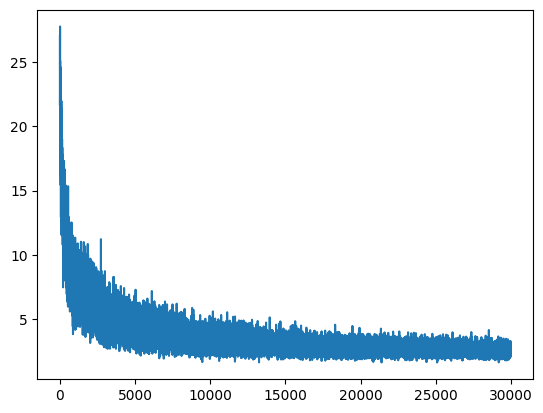

In [ ]:
plt.plot(range(30000),lossi)

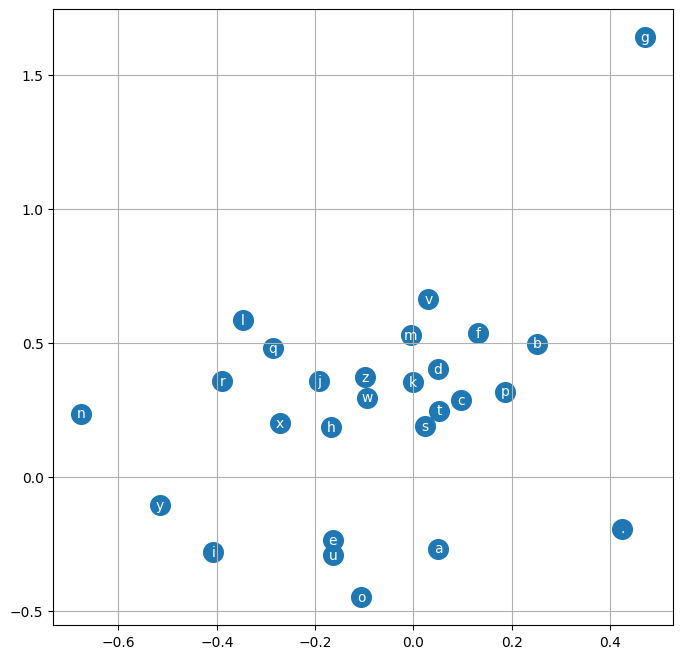

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mona.
kayanniellend.
ryah.
rethan.
endrlee.
azee.
doelin.
shy.
jen.
eden.
esmanaraelynn.
zoura.
nosheberliaghiel.
kinie.
jelionnteron.
uzzey.
dariyah.
faehe.
kaysh.
sanyah.
